# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 5

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from config import *

# This is needed to render the plots in this chapter
from plots.chapter5 import *

In [4]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

# Convolutions

A convolution is "a mathematical operation on two functions (f and g) that produces a
third function (f * g) expressing how the shape of one is modified by the other"[87]. In
image processing, a convolution matrix is also called a kernel or filter. Typical
image processing operations, like blurring, sharpening, edge detection, and more are
accomplished by performing a convolution between a kernel and an image.

## Filter / Kernel

Simply put, one defines a filter (or kernel, but we’re sticking with filter here), and
applies this filter to an image (that is, convolving an image). Usually, the filters are
small square matrices. The convolution itself is performed by applying the filter on
the image repeatedly. Let’s try a concrete example to make it more clear.

We’re using a single-channel image, and the most boring filter ever, the identity
filter:

![](./images/conv1.png)

See the gray region on the top left corner of the image, which has the same size as
the filter? That’s the region the filter is being applied to and it is called the
receptive field, drawing an analogy to the way human vision works.

Moreover, look at the shapes underneath the images: the shapes follow the NCHW
shape convention used by PyTorch. There is one image, one channel, six by six
pixels in size. There is one filter, one channel, three by three pixels in size.

Finally, the asterisk is representing the convolution operation between the two.


Let’s create Numpy arrays to follow the operations, after all, everything gets easier
to understand in code, right?

In [5]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

In [6]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

## Convolving

> "How does the filter modify the selected region/receptive field?"

It is actually quite simple: it performs an element-wise multiplication between the
two, region and filter, and adds everything up. That’s it! Let’s check it out, zooming
in on the selected region:

![](./images/conv2.png)

In code, we have to slice the corresponding region (remember the NCHW shape, so we’re operating on the last two dimensions):

In [7]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

And we’re done for the first region of the image!

> "Wait, there are nine pixel values coming in, but only ONE value
coming out!"

Good point, you’re absolutely right! Doing a convolution produces an image with a
reduced size. It is easy to see why, if we zoom out back to the full image

![](./images/conv3.png)

Since the filter gets applied to the gray region, and we’re using an identity filter, it
is fairly straightforward to see it is simply copying the value in the center of the
region. The remaining values are simply multiplied by zero and do not make to the
sum. But even if they did, it wouldn’t change the fact that the result of one
operation is a single value.

## Moving Around

Next, we move the region one step to the right, that is, we change the receptive
field, and apply the filter again:

![](./images/stride1.png)

> The size of the movement, in pixels, is called a stride. In our
example, the stride is one.

In code, it means we’re changing the slice of the input image:

In [8]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

But the operation remains the same: first, an element-wise multiplication, and then
adding up the elements of the resulting matrix:

![](./images/conv5.png)

In [9]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

![](./images/conv6.png)

We can keep moving the gray region to the right until we can’t move it anymore:

![](./images/conv7.png)

The fourth step to the right will actually place the region partially outside the
input image. That’s a big no-no!

In [10]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

The selected region does not match the shape of the filter anymore. So, if we try to
perform the element-wise multiplication, it fails:

In [11]:
last_horizontal_region * identity

ValueError: operands could not be broadcast together with shapes (1,1,3,2) (1,1,3,3) 

## Shape

Next, we go back to the left side and move down one step. If we repeat the
operation, covering all valid regions, we’ll end up with a resulting image that is
smaller (on the right):

![](./images/conv8.png)

It depends on the size of the filter.

> The bigger the filter, the smaller the resulting image.

Since applying a filter always produces a single value, the reduction is equal to the
filter size minus one. If the input image has (hi, wi) shape (we’re disregarding the channel dimension for now), and the filter has (hf, wf) shape, the shape of the
resulting image is given by:

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

If we assume the filter is a square matrix of size f, we can simplify the expression
above to:

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

Makes sense, right? The filter has its dimensions reduced from (f, f) to (1, 1), so the
operation reduces the original size by (f - 1).

> "But I’d like to keep the image size, is it possible?"

Sure it is! Padding comes to our rescue in this case. We’ll get to that in a couple of
sections.

## Convolving in PyTorch

Now that we know how a convolution works, let’s try it out using PyTorch. First, we
need to convert our image and filter to tensors:

In [12]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

Since kernel and filter are used interchangeably, especially when it comes to
arguments of different methods, I am calling the variable kernel_identity, even
though it is exactly the same identity filter we have used so far.


Just like the activation functions we’ve seen in Chapter 4, convolutions also come
in two flavors: **functional and module**. 

There is a fundamental difference between the two, though: the **functional** convolution takes the **kernel/filter as an argument** while **the module has weights** to represent the kernel/filter.

Let’s use the functional convolution, `F.conv2d`, to apply the identity filter to our input image (notice we’re using `stride=1` since we moved the region around one
pixel at a time):

In [13]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

As expected, we got the same result shown in the previous section. No surprises
here.

Now, let’s turn our attention to PyTorch’s convolution module, `nn.Conv2d`. It has
many arguments, let’s focus on the first four of them:

- `in_channels`: number of channels of the input image
- `out_channels`: number of channels produced by the convolution
- `kernel_size`: size of the (square) convolution filter/kernel
- `stride`: the size of the movement of the selected region

There is a couple of things to notice here. First, there is **no argument for the
kernel/filter itself**, there is only a `kernel_size` argument.

> The **actual filter**, that is, the **square matrix** used to perform
element-wise multiplication is **learned** by the module.

Second, it is possible to produce **multiple channels** as output. It simply means the
module is going to **learn multiple filters**. Each filter is going to produce a different
result, which is being called a channel here.

So far, we’ve been using a single channel image as input, and applying one filter
(size three by three) to it, moving one pixel at a time, resulting in one
output/channel. Let’s do it in code:

In [14]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)

conv(image)

tensor([[[[ 0.2978, -0.5510,  1.3414,  2.1362],
          [-0.4903,  2.7307,  0.1110, -1.9342],
          [-1.4885, -3.5565, -3.3426, -0.0736],
          [ 0.7363,  0.1441,  0.3814,  0.9591]]]],
       grad_fn=<SlowConv2DBackward0>)

These results are gibberish now (and yours are going to be different than mine)
because the convolutional module randomly initializes the weights representing
the kernel/filter.

> That’s the whole point of the convolutional module: it will learn
the kernel/filter on its own.

> In traditional computer vision, people would develop different
filters for different purposes: blurring, sharpening, edge
detection, and so on.

> But, instead of being clever and trying to manually devise a filter
that does the trick for a given problem, why not outsource the
filter definition to the neural network as well? This way. the
network will come up with filters that highlight features that are
relevant to the task at hand.

It’s no surprise that the resulting image shows a `grad_fn` attribute
now: it will be used to compute gradients so the network can
actually learn how to change the weights representing the filter.


> "Can we tell it to learn multiple filters at once?"

Sure we can, that’s the role of the `out_channels` argument. If we set it to two, it will
generate two (randomly initialized) filters:

In [15]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[ 0.2434, -0.0609,  0.2222],
          [-0.0692, -0.2228, -0.0611],
          [ 0.3178, -0.2362, -0.0389]]],


        [[[-0.0895, -0.3298,  0.2559],
          [ 0.0721, -0.1748, -0.0858],
          [ 0.2196,  0.0036,  0.2431]]]], requires_grad=True)

See? There are **two** filters represented by **three-by-three** matrices of weights
(your values are going to be different than mine).

> Even if you have only one channel as input, you can have many
channels as output.

> **Spoiler alert**: the filters learned by the network are going to show
edges, patterns, and even more complex shapes (sometimes
resembling faces, for instance). We’ll get back to visualizing
those filters later in this chapter.

We can also **force** a convolutional module to use a particular filter by setting its
weights:

In [16]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

`weight[0]` and `bias[0]` are indexing the first (and only) output channel in this convolutional layer.

> **IMPORTANT: setting the weights is a strictly no-gradient
operation, so you should always use the no_grad context
manager.**

In the code snippet above, we are forcing the module to use the (boring) identity
kernel we have used so far. As expected, if we convolve our input image we’ll get
the familiar result:

In [17]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<SlowConv2DBackward0>)

> Setting the weights to get specific filters is at the heart of
transfer learning. Someone else trained a model and that model
learned lots of useful filters, so we don’t have to learn them
again. We can set the corresponding weights and go from there.
We’ll see this in practice in Chapter 7.

## Striding

So far, we’ve been moving the region of interest one pixel at a time: a stride of one.
Let’s try a **stride of two** for a change and see what happens to the resulting image. I
am not reproducing the first step here because it is always the same: the gray
region centered at the number nine.

![](./images/strider2.png)

The **second step**, depicted above, shows the **gray region** moved two pixels to the
right: that’s a stride of two.

Moreover, notice that, if we take another step of two pixels, the gray region would be
placed partially outside the underlying image. It was and still is a big no-no, so
there are **only two valid operations** while moving horizontally. The same will
eventually happen when we move vertically. The first stride of two pixels down is
fine, but the second will be, once again, a failed operation.

The resulting image, after the only four valid operations, looks like this:

![](./images/strider3.png)

The identity kernel may be boring, but it is definitely **useful** to highlight the inner
workings of the convolutions. It is crystal clear in the figure above where the pixel
values in the resulting image come from.

Also, notice that using a **bigger stride** made the shape of the resulting image even
smaller.

> The **bigger the stride**, the **smaller the resulting image**.

Once again, it makes sense: if we are **skipping pixels** in the input image, there are
fewer regions of interest to apply the filter to. We can extend our previous formula
to include the stride size (s):

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

As we’ve seen before, the stride is only an argument of the convolution, so let’s use
PyTorch’s functional convolution to double-check the results:

In [18]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

So far, the operations we performed have been shrinking the images. What about
restoring them to their original glory, I mean, size?

## Padding

Padding means stuffing. We need to stuff the original image so it can sustain the
"attack" on its size.

> "How do I stuff an image?"

Glad you asked! We may simply **add zeros around it**. An image is worth a thousand words in this case:

![](./images/padding1.png)

See what I mean? By adding columns and rows of zeros around it, **we expand the
input image** such that the gray region starts centered in the actual top left corner
of the input image. This simple trick can be used to **preserve the original size** of the
image.

In code, as usual, PyTorch gives us two options: functional (`F.pad`) and module
(`nn.ConstantPad2d`). Let’s start with the module version this time:

In [19]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

There are two arguments: `padding`, for the number of columns and rows to be
stuffed in the image; and value, for the value that is filling these new columns and
rows. One can also do **asymmetric padding**, by specifying a tuple in the padding
argument representing (left, right, top, bottom). So, if we were to stuff our
image on left and right sides only, the argument would go like this: (1, 1, 0, 0).

We can achieve the same result using the functional padding:

In [20]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In the functional version, one must specify the **padding as a tuple**. The value
argument is straightforward, and there is yet another argument: `mode`, which was
set to **constant** to match the module version above.

> In PyTorch’s documentation there is a **note** warning about
possible reproducibility issues while using padding:

> *"When using the CUDA backend, this operation may induce
nondeterministic behaviour in its backward pass that is not easily
switched off. Please see the notes on Reproducibility for background."*
It strikes me a bit odd that such a straightforward operation, of all
things, would jeopardize reproducibility. Go figure!

> "What are the other available modes?"

There are three other modes: replicate, reflect, and circular. Let’s take a look at
them, starting with the visualization:

![](images/paddings.png)

In the replication padding, the padded pixels will have the same value as the
closest real pixel. The padded corners will have the same value as the real corners.
The other columns (left and right) and rows (top and bottom) will replicate the
corresponding values of the original image. The values used in the replication are in
a darker shade of orange.

In PyTorch, one can use the functional form `F.pad` with `mode="replicate"`, or use
the module version `nn.ReplicationPad2d`:

In [21]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In the **reflection** padding, it gets a bit trickier. It is like **the outer columns and rows
are used as axes for the reflection**. 

So, the left padded column (forget about the corners for now) will reflect the second column (since the first column is the axis of reflection). The same reasoning goes for the right padded column. Similarly, the top
padded row will reflect the second row (since the first row is the axis of reflection),
and the same reasoning goes for the bottom padded row. The values used in the
reflection are in a darker shade of orange. The corners will have the same values as
the intersection of the reflected rows and columns of the original image.

Hopefully, the image can convey the idea better than my words.

In PyTorch, you can use the functional form F.pad with mode="reflect", or use the
module version nn.ReflectionPad2d:

In [22]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In the circular padding, the left-most (right-most) column gets copied as the right
(left) padded column (forget about the corners for now too). Similarly, the topmost
(bottom-most) row gets copied as the bottom (top) padded row. The corners
will receive the values of the diametrically opposed corner: the top-left padded
pixel receives the value of the bottom-right corner of the original image. Once
again, the values used in the padding are in a darker shade of orange.

In PyTorch, you must use the functional form F.pad with mode="circular" since
there is no module version of the circular padding (at time of writing):

In [23]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

By means of **padding** an image, it is possible to **get resulting images** with the same
shape as input images, or even bigger, should you choose to stuff more and more
rows and columns to the input image. Assuming we’re doing **symmetrical padding
of size p**, the resulting shape is given by the formula below:

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

We’re basically extending the original dimensions by 2p pixels each.

## A REAL Filter

Enough with the identity filter! Let’s try an **edge detector**[88] filter from traditional
computer vision for a change:

In [24]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

And let’s apply it to a different region of our (padded) input image as well:

![](./images/padding2.png)

As you can see, filters, other than the identity one, will not simply copy the value at
the center. The element-wise multiplication finally means something:

![](./images/padding3.png)

In [25]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

# Pooling

Now we’re back in the business of **shrinking images**. Pooling is different than the
former operations: it splits the image into tiny chunks, performs an operation on
each chunk (that yields a single value), and puts the chunks together as the
resulting image. Again, an image is worth a thousand words:

![](./images/pooling1.png)

In the image above, we’re performing a **max-pooling** with a kernel size of two.

Even though these are not quite the same filters as the ones we’ve already seen, it
is still called kernel.

> In this example, the stride is assumed to be the same size as the
kernel.

Our input image is split into nine chunks, and we perform a simple max operation
(hence, max-pooling) on each chunk (really, it is just taking the biggest value in each
chunk). Then these values are put together, in order, to produce a smaller resulting
image.

> The bigger the pooling kernel, the smaller the resulting image.

A pooling kernel of two-by-two results in an image whose dimensions are half of
the original. A pooling kernel of three-by-three makes the resulting image one third the size of the original, and so on. Moreover, **only full chunks count**: if we try a
kernel of four-by-four in our six-by-six image, only one chunk fits, and the resulting
image would have a single pixel.

In PyTorch, as usual, we have both forms: `F.max_pool2d` and `nn.MaxPool2d`. Let’s
use functional form to replicate the max-pooling in the figure above:

In [26]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

And then let’s use the module version to illustrate the big four-by-four pooling:

In [27]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

A single pixel as promised!

> "Can I perform some other operation?"

Sure, besides **max-pooling**, **average pooling** is also fairly common. As the name
suggests, it will output the average pixel value for each chunk. In PyTorch, we have
`F.avg_pool2d` and `nn.AvgPool2d`.

> "Can I use a stride of a different size?"

Of course, you can! In this case, there will be an **overlap** between regions instead of
a clean split into chunks. So, it looks like a regular kernel of a convolution, but the
operation is already defined (max or average, for instance). Let’s go through a
quick example:

In [28]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

The max-pooling kernel, sized three-by-three, will move over the image (just like
the convolutional kernel) and compute the maximum value of each region it goes
over. The resulting shape follows the formula on Equation 5.4.

# Flattening

We’ve already seen this one! It simply flattens a tensor, preserving the first
dimension such that we keep the number of data points while collapsing all other
dimensions. It has a module version nn.Flatten:

In [29]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

It has no functional version, but there is no need for one since we can accomplish
the same thing using view:

In [30]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

### Dimensions

We’ve performed convolutions, padding, and pooling in **two dimensions** because
we’re handling images. But there are one and three-dimensional versions of some
of them as well:

- `nn.Conv1d` and `F.conv1d`; `nn.Conv3d` and `F.conv3d`
- `nn.ConstandPad1d` and `nn.ConstandPad3d`
- `nn.ReplicationPad1d` and `nn.ReplicationPad3d`
- `nn.ReflectionPad1d`
- `nn.MaxPool1d` and `F.max_pool1d`; `nn.MaxPool3d` and `F.max_pool3d`
- `nn.AvgPool1d` and `F.avg_pool1d`; `nn.AvgPool3d` and `F.avg_pool3d`

We will not venture into the third dimension in this book, but we’ll get back to one-dimension
operations later.

- "Aren’t color images three-dimensional since they have three channels?"

Well, yes, but we will still be applying two-dimensional convolutions to them. We’ll
go through a detailed example using a three-channel image in the next chapter.

# Typical Architecture

The typical architecture uses a sequence of one or more typical convolutional
blocks, each block consisting of three operations:

1. Convolution
2. Activation function
3. Pooling

As images go through these operations, they will shrink in size. After three of these
blocks (assuming kernel size of two for pooling), for instance, an image will be
reduced to 1/8 or less of its original dimensions (and thus 1/64 of its total number
of pixels). The number of channels/filters produced by each block, though, is
usually increased as more blocks are added.

After the sequence of blocks, the image gets flattened: hopefully, at this stage,
there is no loss of information by considering each value in the flattened tensor a
feature on its own.

Once the features are dissociated from pixels, it becomes a fairly standard
problem, like the ones we’ve been handling in this book: the features feed one or
more hidden layers, and an output layer produces the logits for classification.


> If you think of it, what those typical convolutional blocks do is
akin to pre-processing images and converting them into
features. Let’s call this part of the network **a featurizer** (the one
that generates features).

> The classification itself is handled by the familiar and well-known
hidden and output layers.

> In transfer learning, which we’ll see in Chapter 7, this will
become even more clear.

## LeNet5

LeNet-5 is a 7-level convolutional neural network developed by Yann LeCun in
1998 to recognize hand-written digits in 28x28 pixel images - the famous **MNIST**
dataset! That’s when it all started (kinda). 

In 1989, LeCun himself used backpropagation (chained gradient descent, remember?) to learn the convolution
filters, as we discussed above, instead of painstakingly developing them manually.

His network had this architecture:

![](images/architecture_lenet.png)

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

Do you see anything familiar? The typical convolutional blocks are already there
(to some extent): convolutions (C layers), activation functions (not shown), and
subsampling (S layers). There are some differences, though:

- back then, the subsampling was more complex than today’s max-pooling, but the general idea still holds

- the activation function, a sigmoid at the time, was applied after the subsampling instead of before, as it is typical today

- the F6 and OUTPUT layers were connected by something called "Gaussian connections", which is also more complex than the typical activation function one would use today

Adapting LeNet-5 to today’s standards, it could be implemented like this:

In [31]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))

# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))

# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())

# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

LeNet-5 used three convolutional blocks, although the last one does not have a max-pooling because the convolution already produces a single pixel. Regarding the number of channels, they increase as the image size decreases:

- input image: single-channel 28x28 pixels
- first block: produces 6-channel 14x14 pixels
- second block: produces 16-channel 5x5 pixels
- third block: produces 120-channel single-pixel (1x1)

Then, these 120 values (or features) are flattened and fed to a typical hidden layer
with 84 units. The last step is, obviously, the output layer, which produces 10 logits
to be used for digit classification (from 0 to 9, there are 10 classes).

> "Wait, we haven’t seen any of those multiclass classification problems yet!"

You’re right, it is about time. But we’re still not using MNIST for this.

# A Multiclass Classification Problem

A problem is considered a multiclass classification problem if there are more than
two classes. So, let’s keep it as simple as possible and build a model to classify
images into three classes.

## Data Generation

Our images are going to have either a diagonal or a parallel line, BUT this time we
will make a distinction between a diagonal line tilted to the right, a diagonal line
tilted to the left, and a parallel line (it doesn’t matter if it is horizontal or vertical).
We can summarize the labels (y) like this:

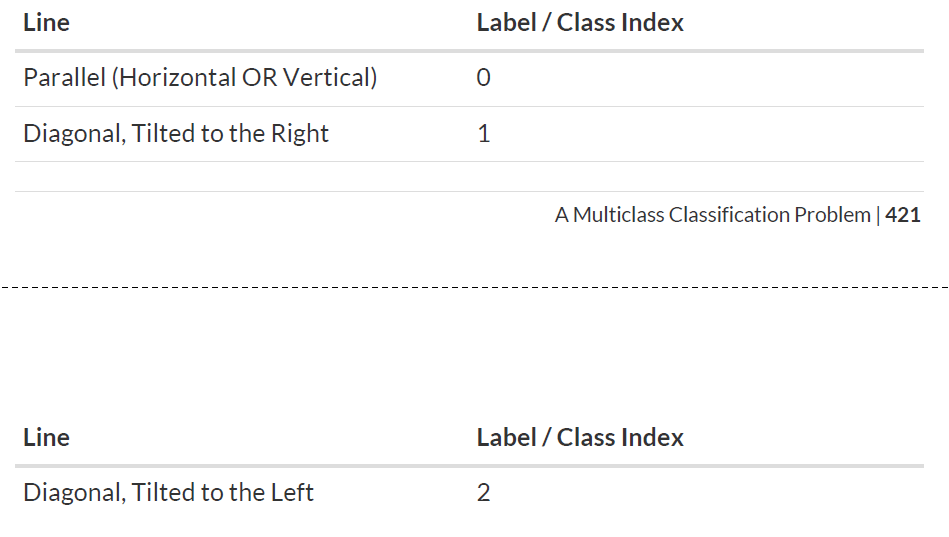

Also, let’s generate more and bigger images: one thousand images, each one ten-by-
ten pixels in size

In [32]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

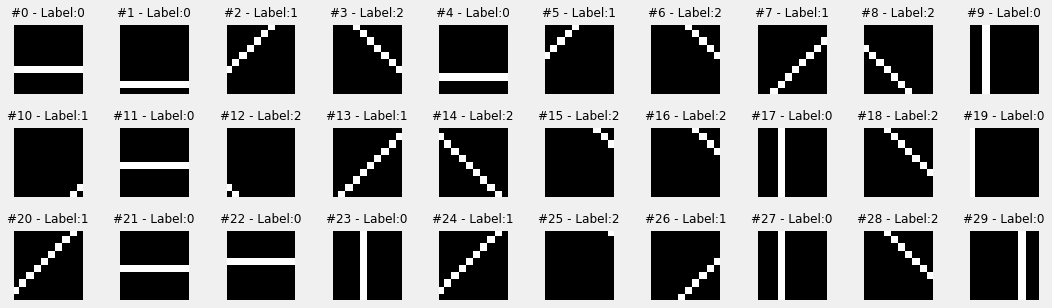

In [33]:
fig = plot_images(images, labels, n_plot=30)

## Data Preparation

The data preparation step would be identical to the one we used in Chapter 4 if it
weren’t for one change: we will not perform data augmentation this time.

> "Why not?"

In our particular problem, flipping an image is potentially ruining the label. If we
have an image containing a diagonal line tilted to the right (thus labeled as class
index #1), and we flip it, the diagonal line would end up tilted to the left. But data
augmentation does not change the labels, so the result is an image with a wrong
label (class index #1, even though it would contain a left-tilted diagonal line).

> Data augmentation may be useful, but it should not produce
images that are inconsistent with their labels.

That being said, we’re only keeping the min-max scaling using the Normalize
transform. All the rest remains the same: splitting, datasets, sampler, and data
loaders.

In [34]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

Data preparation.

In [35]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Loss

New problem, new loss. Since we’re embracing multiclass classification now, we
need to use a different loss. And, once again, it all starts with our "favorite" subject:
logits.

#### Logits

In binary classification problems, the model would produce one logit, and one logit
only, for each data point. It makes sense, binary classification is about answering a
simple question: "does a given data point belong to the positive class?".

The **logit** output represented the log odds ratio (remember that?) of answering
"yes" to the question above. The log odds ratio of a "no" answer was simply the
inverse. There was no need to pose any other question to make a decision. And we
used a sigmoid function to map logits to probabilities. It was a simple world :-)
But a multiclass classification is more complex: we need to ask more questions,
that is, **we need to get log odds ratios for every possible class. In other words, we
need as many logits as there are classes.**

> "But a sigmoid takes only one logit. I guess we need something else to get probabilities, right?"

Absolutely correct! The function we’re looking for here is called **softmax**.


### Softmax

The softmax function returns, for each class, the contribution that a given class
had to the **sum of odds ratios**. The class with a higher odds ratio will have the
biggest contribution and thus the **highest probability**.

> Since the **softmax** is computed using odds ratios instead of log
odds ratios (logits), we need to exponentiate the logits!

$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

The softmax formula itself is quite simple:

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{N_c-1}{e^{z_c}}}
$$

In the equation above, C stands for the number of classes and i corresponds to the
index of a particular class. In our example, we have three classes, so our model
needs to output three logits (z0, z1, z2). Applying softmax to these logits, we would
get:

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

Simple, right? Let’s see it in code now. Assuming our model produces this tensor
containing three logits:

In [36]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

We exponentiate the logits to get the corresponding odds ratios:

In [37]:
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

The resulting tensor is telling us that the first class **has much better odds** than the other two, and the second one has better odds than the third. So we take these
odds and add them together, and then compute the each class' contribution to the
sum:

In [38]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

Voilà! Our logits were softmaxed: the probabilities are proportional to the odds
ratios. This data point most likely belongs to the first class since it has a probability
of 72.73%.
But there is absolutely no need to compute it manually, of course. PyTorch
provides the typical implementations: functional (F.softmax) and module
(nn.Softmax):

In [39]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

In both cases, it asks you to **provide which dimension** the softmax function should
be applied to. In general, our models will produce logits with the shape (number of
data points, number of classes), so **the right dimension to apply softmax to is the
last one (dim=-1).**

#### LogSoftmax.

The logsoftmax function returns, well, the logarithm of the softmax function
above. But, instead of manually taking the logarithm, PyTorch provides
`F.log_softmax` and `nn.LogSoftmax` out of the box.

These functions are **faster** and also have **better numerical properties**. But, I guess your main question at this point is:

> "Why do I need to take the log of the softmax?"

The simple and straightforward reason is that **the loss function expects log-probabilities as input.**


### Negative Log Likelihood Loss

Since the softmax returns **probabilities**, the logsoftmax returns **log-probabilities**. And that’s the input for computing the **negative log-likelihood loss**, or `NLLLoss` for short. 

This loss is simply an extension of the binary cross-entropy loss to handle multiple classes.

This was the formula for computing binary cross-entropy:

$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
\\
$$

See the log-probabilities in the summation terms? In our example, there are three
classes, that is, our labels (y) could be either zero, one, or two. So, the loss function
will look like this:

$$
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
\\
$$

Take, for instance, the first class (**y=0**). For every data point belonging to this class
(there are **N0** of them), we take the logarithm of the predicted probability for that
point and class *(log(P(yi=0)))* and add them all up. Next, we repeat the process for
the other two classes, add all three results up, and divide by the total number of
data points.

> The loss only considers the predicted probability for the true
class.

If a data point is labeled as belonging to class index two, the loss will consider the
probability assigned to class index two only. The other probabilities will be
completely ignored.

For a total of C classes, the formula can be written like this:

$$
\\
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

Since the **log-probabilities** are obtained by applying **logsoftmax**, this loss isn’t
doing much more than looking up the inputs corresponding to the true class and
adding them up. Let’s see this in code:

In [40]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

These are the log-probabilities for each class we computed using logsoftmax for
our single data point. Now, let’s assume its label is two: what is the corresponding
loss?

In [41]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label)

tensor(2.3979)

It is the **negative** of the **log-probability** corresponding to the class index (two) of
the true label.

As you’ve probably noticed, I used the **functional** version of the loss in the snippet of
code above: F.nll_loss. But, as we’ve done with the binary cross-entropy loss in
Chapter 3, we’re likely using the module version: nn.NLLLoss.

Just like before, this loss function is a higher-order function, and this one takes
three optional arguments (the others are deprecated and you can safely ignore
them):

- `reduction`: it takes either mean, sum, or none. The default, mean, corresponds to our Equation 5.10 above. As expected, sum will return the sum of the errors, instead of the average. The last option, none, corresponds to the unreduced form, that is, it returns the full array of errors.

- `weight`: it takes a tensor of length C, that is, containing as many weights as there are classes.

> IMPORTANT: this argument can be used to **handle imbalanced
datasets**, unlike the weight argument in the binary cross-entropy
losses we’ve seen in Chapter 3.
Also, unlike the `pos_weight` argument of `BCEWithLogitsLoss`, the
NLLLoss computes a true weighted average when this argument
is used.

- ignore_index: it takes one integer, corresponding to the one (and only one) class index that should be ignored when computing the loss. It can be used to mask a particular label that is not relevant to the classification task.

Let’s go through some quick examples using the arguments above. First, we need to
generate some dummy logits (we’ll keep using three classes, though), and the
corresponding log-probabilities

In [42]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
#print(dummy_logits)
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

> Can you hand-pick the log-probabilities that are going to be
actually used in the loss computation?

In [43]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
-relevant_log_probs.mean()

tensor(1.6553)

Now let’s use `nn.NLLLoss` to create the actual loss function, and then use
predictions and labels to check if we got the relevant log-probabilities right:

In [44]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

Right indeed! What if we want to balance our dataset, giving data points with label
(y=2) double the weight of the other classes?

In [45]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

And what if we want to simply ignore data points with label (y=2)?

In [46]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.5599)

And, once again, there is yet another loss function available for multiclass
classification. And, once again, it is very important to know when to use one or the
other, so you don’t end up with an inconsistent combination of model and loss
function.

### Cross Entropy Loss

The former loss function took log-probabilities as an argument (together with the
labels, obviously). Guess what this function takes? **Logits**, of course! This is the
multiclass version of `nn.BCEWithLogitsLoss`.

> "What does it mean, in practical terms?"

It means **you should NOT add a logsoftmax** as the last layer of your model when
using this loss function. This loss combines both the **logsoftmax layer and the
former negative log-likelihood loss into one**.

> **IMPORTANT**: I can’t stress this enough: you must use the right
combination of model and loss function.

> **Option 1**: `nn.LogSoftmax` as the last layer, meaning your model is
producing log-probabilities, combined with `nn.NLLLoss` function

> **Option 2**: no logsoftmax in the last layer, meaning your model is
producing logits, combined with `nn.CrossEntropyLoss` function.

> Mixing nn.LogSoftmax and nn.CrossEntropyLoss is just wrong.

Now that the difference in the arguments is clear, let’s take a closer look at the
`nn.CrossEntropyLoss` function. It is also a higher-order function, and it takes the
same three optional arguments as nn.NLLLoss:

- `reduction`: it takes either mean, sum, or none, and the default is mean.
- `weight`: it takes a tensor of length C, that is, containing as many weights as there are classes.
- `ignore_index`: it takes one integer, corresponding to the one (and only one) class index that should be ignored.

Let’s see a quick example of its usage, taking the dummy logits as input:

In [47]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

No logsoftmax whatsoever but the same resulting loss, as expected.

#### Classification Losses Showdown!

Honestly, I always felt this whole thing is a bit confusing, especially for someone who’s learning it for the first time.

Which loss functions take logits as inputs? Should I add a (log)softmax layer or not?

Can I use the weight argument to handle imbalanced datasets? Too many questions, right?

So, here is a table to help you figure out the landscape of loss functions for
classification problems, both binary and multiclass:

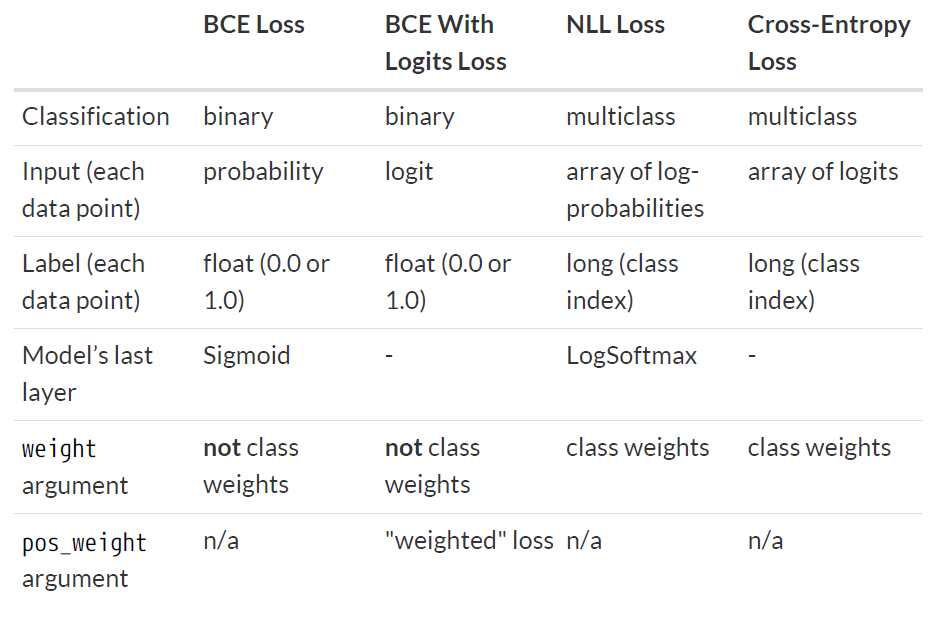

## Model Configuration

Let’s build our first convolutional neural network for real! We can use the typical
convolutional block: convolutional layer, activation function, pooling layer. Our images are quite small, so we only need one of those.

We still need to decide **how many channels** our convolutional layer is going to
produce. In general, the number of channels **increases** with each convolutional
block. For the sake of simplicity (and later visualization), let’s keep a single channel.

We also need to decide on a **kernel size** (the receptive field or gray regions in the
figures at the beginning of this chapter). Let’s stick with a kernel size of three,
which will reduce the image size by two pixels in each dimension (we are not using
padding here).

Our **featurizer**, which will encode our images into features using convolutions,
should look like this:

In [50]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))

# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

I am keeping the number of channels as a variable, so you can try different values
for it if you like.

Let’s follow what happens to an input image (single-channel, 10x10 pixels in size -
1@10x10):

- the image is convolved with the kernel and the resulting image has one channel, and it is 8x8 pixels in size (1@8x8)
- a ReLU activation function is applied to the resulting image
- the "activated" image goes under a max-pooling operation with a kernel size of two, so it is divided into 16 chunks of size two-by-two, resulting in an image with one channel, but 4x4 pixels in size (1@4x4)
- these 16 values can be considered features, and are flattened into a tensor with 16 elements

The next part of our model, the classifier part, uses these features to feed what would be a simple neural network with a single hidden layer if considered on its own:

In [51]:
# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

See? There is a hidden layer that takes the 16 features as inputs and maps them
into a 10-dimensional space that is going to be "activated" by the ReLU.

Then, the output layer produces **three distinct linear combinations of the ten
activation values**, each combination corresponding to a different class. The figure
below, depicting the second half of the model, should make it more clear:

![](images/classification_softmax.png)

The three units in the output layer produce **three logits**, one for each class (C0, C1,
and C2). We could have added a nn.LogSoftmax layer to the model, and it would
convert the three logits to log-probabilities.

Since our model produces logits, we must use the nn.CrossEntropyLoss function:

In [52]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

And then we create an optimizer (SGD) with a given learning rate (0.1), as usual.
Boring, right? No worries, we’ll finally change the optimizer in the "Rock-Paper-
Scissors" classification problem in the next chapter.

## Model Training

This part is completely straightforward. First, we instantiate our class, and set the
loaders:

In [53]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

Then, we train it for 20 epochs, and visualize the losses:

In [54]:
sbs_cnn1.train(20)

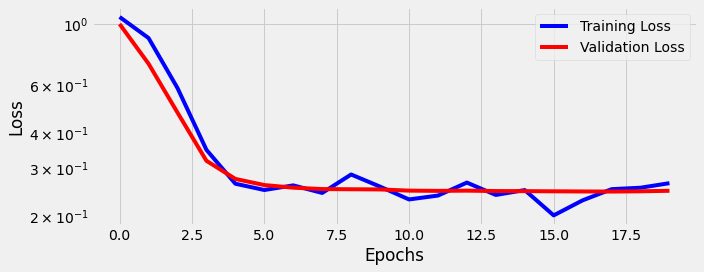

In [55]:
fig = sbs_cnn1.plot_losses()

OK, it seems to have reached a minimum at the fifth epoch already.

## Visualizing Filters and More!

In Chapter 4, we briefly discussed visualizing weights as pixels. We’re going to dive
deeper into the visualization of filters (weights), as well as the transformed images
produced by each one of our model’s layers.

First, let’s add another method to our tool belt:

In [56]:
@staticmethod
def _visualize_tensors(axs, x, y=None, yhat=None, 
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray', 
            vmin=minv, 
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

Most of the function’s body is handling titles, labels, and axes' ticks before using
imshow to actually plot the image, so it is not that interesting. Let’s check its
arguments:

- `axs`: an array of subplots, corresponding to one row of subplots as returned by Matplotlib’s subplot
- `x`: a Numpy array containing at least as many images/filters as subplots in axs
- `y`: optional, a Numpy array containing at least as many labels as subplots in axs
- `yhat`: optional, a Numpy array containing at least as many predicted labels as subplots in axs
- `layer_name`: label for the row of subplots
- `title`: title prefix for each subplot

> "What is that @staticmethod thingy above the method’s definition?"

### Static Method

The `“@”` indicates that the method sitting below it, `_visualize_tensors` is
being decorated by the staticmethod decorator function.

> "What is a decorator?"

Python decorators is a big topic on its own, too long to explain here. If you
want to learn more about it, check Real Python’s Primer on Python
Decorators[90]. But I am not leaving you without a working knowledge of
what that particular (and somewhat common) decorator is doing.

The `@staticmethod` decorator **allows the method to be called on an
uninstantiated class object**. It is as if we’re attaching a method to a class that
does not depend on an instance of the class it is attached to.

It is easy to see why: in every other method we have created so far for the
StepByStep class, **the first argument was ALWAYS self**. So, those methods
had access to the class they belonged to, better yet, they had access to a
particular instance and its attributes. Remember the Dog class? The bark
method knew the name of the dog because its first argument was the
instance representing the dog (self).

> A static method does **not have a self argument**. The inner
workings of the function must be independent of the
instance of the class it belongs to.
> The static method **can be executed** from the class itself
instead of one of its instances.

Let me illustrate it with yet another silly example:

In [57]:
class Cat(object):
    def __init__(self, name):
        self.name = name

    @staticmethod
    def meow():
        print('Meow')

The meow method is totally independent of the Cat class. **We do not even need
to create a cat!** That’s what I meant with "called on an uninstantiated class
object":

In [59]:
Cat.meow()

Meow


See? The meow method could well be an independent function because it
works like one. But, in the context of a cat class, it makes sense to have that
method attached to it since they belong together, conceptually speaking.

Back to our own static method, we’ll call it from other (regular) methods to plot the
images we’re interested in. Let’s start with the filters.

### Visualizing Filters

We could apply the same principle to the **weights of the filter learned by our
convolutional layer**. We can access the weights of any given layer using dot
notation:

In [60]:
weights_filter = model_cnn1.conv1.weight.data.cpu().numpy()
weights_filter.shape

(1, 1, 3, 3)

Each layer has its own weight attribute, which is a `nn.Parameter`. We could use it
directly, but then we would also have to **detach** the parameter from the
computation graph before converting it to Numpy. So, it is **easier to use the `data`
attribute of weight because it is simply a tensor, and no detaching is needed.**

The shape of the weights (representing the filters) of a two-dimensional
convolutional layer is given by **(out_channels, in_channels, kernel_size,
kernel_size)**. In our case, the kernel size is three, and we have a single channel, both
in and out, hence the shape of the weights is (1, 1, 3, 3).

And that’s when the **static method** we developed in the previous section comes in
handy: we can loop through the filters (output channels) that the model learned to
convolve each one of the input channels.

In [62]:
def visualize_filters(self, layer_name, **kwargs):
    try:
        # Gets the layer object from the model
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # We are only looking at filters for 2D convolutions
        if isinstance(layer, nn.Conv2d):
            # Takes the weight information
            weights = layer.weight.data.cpu().numpy()
            # weights -> (channels_out (filter), channels_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Builds a figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels, 
                                     figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # For each channel_out (filter)
            for i in range(n_filters):    
                StepByStep._visualize_tensors(
                    axes[i, :],   # The i-th row of subplots corresponds to a particular filter, 
                                  # each row has as many columns as there are input channels
                    weights[i],   # The i-th element of the weights corresponds to the i-th filter,
                                  # which learned different weights to convolve each one of the input channels
                    layer_name=f'Filter #{i}', 
                    title='Channel'
                )
                    
            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
    except AttributeError:
        return
    
setattr(StepByStep, 'visualize_filters', visualize_filters)

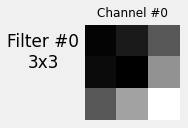

In [63]:
fig = sbs_cnn1.visualize_filters('conv1', cmap='gray')

Is this a filter one could come up with to try distinguishing between the different
classes we have? Maybe, but just by looking at this filter, it is not easy to grasp what
it is effectively accomplishing.

To **really understand** the effect this filter has on each image, we need to **visualize
the intermediate values produced by our model**, namely, the output of each and
every layer!

> "How can we visualize the output of each layer? Do we have to modify our StepByStep class to capture those?"

It is much easier than that: we can use **hooks**!

### Hooks

A hook is simply a way to force a model to execute a function either after its
**forward or after its backward pass**. Hence, there are forward hooks and backward
hooks. We’re using only forward hooks here, but the idea is the same for both.

First, we create a function that is going to be, guess what, hooked to the forward
pass. Let’s illustrate the process with a dummy model:

In [64]:
dummy_model = nn.Linear(1, 1)

dummy_list = []

def dummy_hook(layer, inputs, outputs):
    dummy_list.append((layer, inputs, outputs))

,The (forward) hook function takes three arguments:

- a model (or layer)
- a tensor representing the inputs taken by that model (or layer)
- a tensor representing the outputs generated by that model (or layer)

So, any function taking three arguments, regardless of their names, can work as a
hook. In our case (and in many other cases too), we would like to **keep the
information** that goes through the hook function.

> You should use a variable (or variables) defined **outside** the
hook function to store values.

That’s the role of the `dummy_list` variable in the snippet above. Our dummy_hook
function is as basic as it gets: it simply appends a tuple of its three arguments to the
dummy_list variable defined outside the hook function.

> "How to hook the hook function to the model?"

There is a method for it: `register_forward_hook`, which takes the hook function
and returns a handle, so we can keep track of the hooks attached to our model.

In [65]:
dummy_handle = dummy_model.register_forward_hook(dummy_hook)
dummy_handle

Simple enough, right? Let’s see it in action:

In [66]:
dummy_x = torch.tensor([0.3])
dummy_model.forward(dummy_x)

tensor([-0.8366], grad_fn=<AddBackward0>)

It should add a new tuple to the dummy list, containing a linear layer, an input
tensor (0.3), and an output tensor (-0.7514). By the way, your values are going to be
different than mine, since we didn’t bother to use a seed here.

In [67]:
dummy_list

[]

> "Empty?! So it is not working?"

GOTCHA! I deliberately used the model’s forward method here to illustrate
something we’ve discussed much earlier, in Chapter 1:

> You should NOT call the forward(x) method! You should call the
whole model instead, as in model(x) to perform a forward pass.
Otherwise, your hooks won’t work.

Let’s do it right this time:

In [68]:
dummy_model(dummy_x)

tensor([-0.8366], grad_fn=<AddBackward0>)

In [69]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-0.8366], grad_fn=<AddBackward0>))]

Now we’re talking! Here is the tuple we were expecting! If you call the model once
again, it will append yet another tuple to the list, and so on and so forth. This hook
is going to be hooked to our model until it is explicitly removed (hence the need to
keep the handles). To remove a hook, you can simply call its remove method:

In [70]:
dummy_handle.remove()

And the hook goes bye-bye! But we did not lose the collected information, since
our variable, dummy_list was defined outside the hook function.

Look at the first element of the tuple: it is an instance of a model (or layer). Even if
we use a Sequential model and name the layers, the names won’t make it to the
hook function. So **we need to be clever here and make the association ourselves.**

Let’s get back to our real model now. We can get a list of all its named modules
using the appropriate method: named_modules (what else could it be?!):

In [71]:
modules = list(sbs_cnn1.model.named_modules())
modules

[('',
  Sequential(
    (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (relu2): ReLU()
    (fc2): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=16, out_features=10, bias=True)),
 ('relu2', ReLU()),
 ('fc2', Linear(in_features=10, out_features=3, bias=True))]

The first, unnamed, module is the whole model itself. The other modules are its
layers. And those layers are one of the inputs of the hook function. So, we need to
be able to look up the name, given the corresponding layer instance… if only
there was something we could use to easily look up values, right?

A dictionary is perfect for that: the hook function will take the layer instance as
argument, and look its name up in the dictionary!

In [72]:
layer_names = {layer: name for name, layer in modules[1:]}
layer_names

{Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)): 'conv1',
 ReLU(): 'relu1',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp1',
 Flatten(start_dim=1, end_dim=-1): 'flatten',
 Linear(in_features=16, out_features=10, bias=True): 'fc1',
 ReLU(): 'relu2',
 Linear(in_features=10, out_features=3, bias=True): 'fc2'}

OK, it is time to create a real hook function:

In [73]:
visualization = {}

def hook_fn(layer, inputs, outputs):
    name = layer_names[layer]
    visualization[name] = outputs.detach().cpu().numpy()

It is actually quite simple: it looks up the name of the layer and uses it as a key to a
dictionary defined outside the hook function, which will store the outputs
produced by the hooked layer. The inputs are being ignored in this function.

We can make a list of the layers we’d like to get the outputs from, loop through the
list of named modules, and hook our function to the desired layers, **keeping the
handles in another dictionary**:

In [76]:
layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']

handles = {}

for name, layer in modules:
    if name in layers_to_hook:
        handles[name] = layer.register_forward_hook(hook_fn)

Everything is in place now! The only thing left to do is to actually call the model, so
a forward pass is triggered, the hooks are executed, and the outputs to all these
layers are stored in the visualization dictionary.

Let’s fetch one mini-batch from the validation loader and use the predict method
of our StepByStep class (which will then call the trained model):

In [77]:
images_batch, labels_batch = iter(val_loader).next()
logits = sbs_cnn1.predict(images_batch)

Now, if everything went well, our visualization dictionary should contain one key
for each layer we hooked a function to:

In [78]:
visualization.keys()

dict_keys(['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

Bingo! They are all there! But, before checking what’s stored inside it, let’s remove
the hooks:

In [79]:
for handle in handles.values():
    handle.remove()
handles = {}

> ! Make sure to always remove the hooks after they served their
purpose to avoid unnecessary operations that may slow down
your model.

Maybe I got you hooked (sorry, I really like puns!), maybe not. Anyway, to make it
easier for you to get some layers hooked so you can take a peek at what they are
producing, we’re appending some methods to our StepByStep class: **attach_hooks
and remove_hooks**.

First, we are creating two dictionaries as attributes, visualization and handles,
which will be the externally defined variables (external to the methods, that is).

The attach_hooks method has its own, internal, hook function that is going to store
a layer’s outputs in the visualization attribute. The method handles everything
for us: mapping between layer instances and their names, and registering the hook
function with the desired layers.

The remove_hooks is pretty much exactly the same code, except for the fact that it
uses the handles attribute now.

In [80]:
setattr(StepByStep, 'visualization', {})
setattr(StepByStep, 'handles', {})

def attach_hooks(self, layers_to_hook, hook_fn=None):
    # Clear any previous values
    self.visualization = {}
    # Creates the dictionary to map layer objects to their names
    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules[1:]}

    if hook_fn is None:
        # Hook function to be attached to the forward pass
        def hook_fn(layer, inputs, outputs):
            # Gets the layer name
            name = layer_names[layer]
            # Detaches outputs
            values = outputs.detach().cpu().numpy()
            # Since the hook function may be called multiple times
            # for example, if we make predictions for multiple mini-batches
            # it concatenates the results
            if self.visualization[name] is None:
                self.visualization[name] = values
            else:
                self.visualization[name] = np.concatenate([self.visualization[name], values])

    for name, layer in modules:
        # If the layer is in our list
        if name in layers_to_hook:
            # Initializes the corresponding key in the dictionary
            self.visualization[name] = None
            # Register the forward hook and keep the handle in another dict
            self.handles[name] = layer.register_forward_hook(hook_fn)

def remove_hooks(self):
    # Loops through all hooks and removes them
    for handle in self.handles.values():
        handle.remove()
    # Clear the dict, as all hooks have been removed
    self.handles = {}
    
setattr(StepByStep, 'attach_hooks', attach_hooks)
setattr(StepByStep, 'remove_hooks', remove_hooks)

The procedure is fairly straightforward now: give it a list containing the names of
the layers to attach hooks to, and you’re done!

In [81]:
sbs_cnn1.attach_hooks(layers_to_hook=['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

To get the visualization attribute filled with values, we still need to make
predictions:

In [84]:
images_batch, labels_batch = iter(val_loader).next()
logits = sbs_cnn1.predict(images_batch)

Don’t forget to remove the hooks after you’re finished with the predictions. By the
way, you can call predict multiple times and the outputs produced by the hooked
layers will be concatenated

In [85]:
sbs_cnn1.remove_hooks()

Before moving on, don’t forget the model is producing logits as outputs. To get the
predicted classes, we can simply **take the index of the largest logit for each data
point**:

In [86]:
predicted = np.argmax(logits, 1)
predicted

array([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0], dtype=int64)

We’ll use the predicted classes in the next section

### Visualizing Feature Maps

First, let’s visualize the first ten images sampled from the validation loader

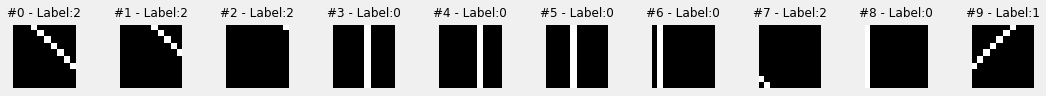

In [87]:
fig = plot_images(images_batch.squeeze(), labels_batch.squeeze(), n_plot=10)

The first part of our model, which we called **featurizer**, has **four layers**: three in a
typical convolutional block, and a flattening layer. The **outputs of these layers are
the feature maps**, which were captured by our hook function when we made
predictions for the first mini-batch of the validation loader.

To visualize the feature maps, we can add another method to our class:
`visualize_outputs`. This method **simply retrieves the captured feature maps** from
the visualization dictionary and uses our _visualize_tensors method to plot
them:

In [88]:
def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
    layers = filter(lambda l: l in self.visualization.keys(), layers)
    layers = list(layers)
    shapes = [self.visualization[layer].shape for layer in layers]
    n_rows = [shape[1] if len(shape) == 4 else 1 
              for shape in shapes]
    total_rows = np.sum(n_rows)

    fig, axes = plt.subplots(total_rows, n_images, 
                             figsize=(1.5*n_images, 1.5*total_rows))
    axes = np.atleast_2d(axes).reshape(total_rows, n_images)
    
    # Loops through the layers, one layer per row of subplots
    row = 0
    for i, layer in enumerate(layers):
        start_row = row
        # Takes the produced feature maps for that layer
        output = self.visualization[layer]
            
        is_vector = len(output.shape) == 2
        
        for j in range(n_rows[i]):
            StepByStep._visualize_tensors(
                axes[row, :],
                output if is_vector else output[:, j].squeeze(),
                y, 
                yhat, 
                layer_name=layers[i] \
                           if is_vector \
                           else f'{layers[i]}\nfil#{row-start_row}',
                title='Image' if (row == 0) else None
            )
            row += 1
            
    for ax in axes.flat:
        ax.label_outer()

    plt.tight_layout()
    return fig

setattr(StepByStep, 'visualize_outputs', visualize_outputs)

Then, let’s use the method above to plot the feature maps for the layers in the
featurizer part of our model:

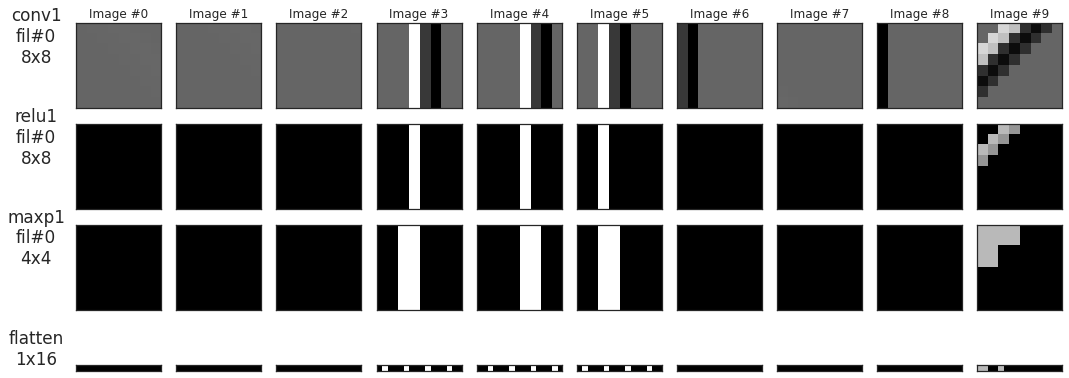

In [89]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(featurizer_layers)

Looks cool, right? Even though I’ve plotted the images in the first four rows with
the same size, they have different dimensions, as indicated by the row labels on the
left. The shade of gray is also computed per row: the maximum (white) and
minimum (black) values were computed across the ten images produced by a given
layer, otherwise, some rows would be too dark (the ranges vary a lot from one layer
to the next).

What can we learn from these images? First, convolving the learned filter with the
input image produces some interesting results:

- for diagonals tilted to the left (images #0, #1, #2, and #7), the filter seems to suppress the diagonal completely
- for parallel lines (only verticals in the example above, images #3 to #6, and #8), the filter produces a striped pattern, brighter to the left of the original line, darker to its right
- for diagonals tilted to the right (only image #9), the filter produces a thicker line with multiple shades

Then, the ReLU activation function removes the negative values. Unfortunately,
after this operation, images #6 and #8 (parallel vertical lines) had all lines
suppressed and seem indistinguishable from images #0, #1, #2, and #7 (diagonals
tilted to the left).

Next, max-pooling reduces the dimensions of the images, and they get flattened to
represent 16 features.

Now, look at the **flattened features**. That’s what the classifier will look at to try to
split the images into three different classes. For a relatively simple problem like
this, we can pretty much see the patterns there. Let’s see what the classifier layers
can make of it.

### Visualizing Classifier Layers

The second part of our model, which is aptly called a classifier, has the typical
structure: a hidden layer (FC1), an activation function, and an output layer (FC2).
Let’s visualize the outputs of each and every one of these layers that were
captured by our hook function for the same ten images:

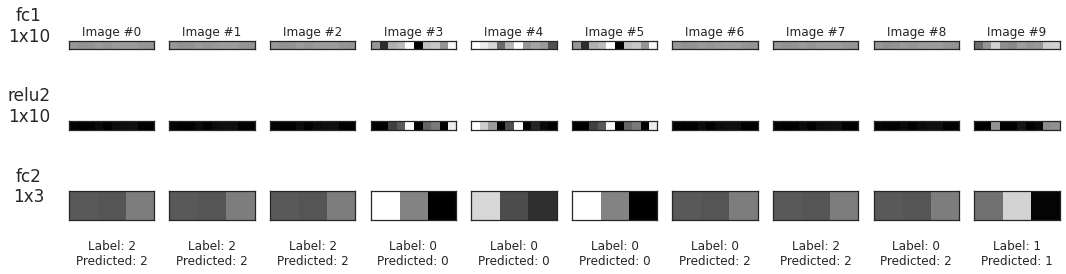

In [90]:
classifier_layers = ['fc1', 'relu2', 'fc2']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

The hidden layer performed an **affine transformation** (remember those?), reducing
the dimensionality from 16 to 10 dimensions. Next, the activation function, a ReLU,
eliminated negative values, resulting in the "activated" feature space in the middle
row.

Finally, the output layer used these 10 values to compute **three logits**, one for each
class. Even without transforming them into probabilities, we know that the biggest
logit wins. The biggest logit is shown as the brightest pixel, so we can tell which
class was predicted by looking at the three shades of gray and picking the index of
the brightest one.

The classifier got eight out of ten right. It made wrong predictions for images #6
and #8. **Unsurprisingly, these are the two images that got their vertical lines
suppressed**. The filter doesn’t seem to work so well whenever the vertical line is
too close to the left edge of the image.

### Accuracy

In Chapter 3, we made predictions using our own predict method and used Scikit- Learn’s metrics module to evaluate them. Now, let’s build a method that takes features (x) and labels (y), as returned by a data loader, and that takes all necessary steps to produce two values for each class: the number of correct predictions, and the number of data points in that class.

In [91]:
def correct(self, x, y, threshold=.5):
    self.model.eval()
    yhat = self.model(x.to(self.device))
    y = y.to(self.device)
    self.model.train()
    
    # We get the size of the batch and the number of classes 
    # (only 1, if it is binary)
    n_samples, n_dims = yhat.shape
    if n_dims > 1:        
        # In a multiclass classification, the biggest logit
        # always wins, so we don't bother getting probabilities
        
        # This is PyTorch's version of argmax, 
        # but it returns a tuple: (max value, index of max value)
        _, predicted = torch.max(yhat, 1)
    else:
        n_dims += 1
        # In binary classification, we NEED to check if the
        # last layer is a sigmoid (and then it produces probs)
        if isinstance(self.model, nn.Sequential) and \
           isinstance(self.model[-1], nn.Sigmoid):
            predicted = (yhat > threshold).long()
        # or something else (logits), which we need to convert
        # using a sigmoid
        else:
            predicted = (F.sigmoid(yhat) > threshold).long()
    
    # How many samples got classified correctly for each class
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()
        n_correct = (predicted[y == c] == c).sum().item()
        result.append((n_correct, n_class))
    return torch.tensor(result)

setattr(StepByStep, 'correct', correct)

If the labels have two or more columns, it means we’re dealing with a multiclass
classification: the predicted class is the one with the biggest logit.

If there is a single column of labels, that would be a binary classification: the
predicted class will be the positive class if the predicted probability is above a
given threshold (usually 0.5). But there’s a catch here: if the last layer of the model
is not a sigmoid, we need to apply it to the logits first to get the probabilities, and
only then compare them with the threshold.

Then, for each possible class, it figures how many predictions match the labels, and
appends the result to a tensor. The shape of the resulting tensor will be (number of
classes, 2), the first column representing correct predictions, the second, the
number of data points.

Let’s try applying this new method to the first mini-batch of our data loader:

In [92]:
sbs_cnn1.correct(images_batch, labels_batch)

tensor([[5, 7],
        [3, 3],
        [6, 6]])

So, there are only two wrong predictions, both for class #0 (parallel lines),
corresponding to images #6 and #8, as we’ve already seen in the previous section.

> "What if I want to compute it for all mini-batches in a data loader?"

### Loader Apply

On it! That’s the role of the static method loader_apply: it applies a function to
each mini-batch, and stack the results before applying a reducing function such as
sum or mean:

In [93]:
@staticmethod
def loader_apply(loader, func, reduce='sum'):
    results = [func(x, y) for i, (x, y) in enumerate(loader)]
    results = torch.stack(results, axis=0)

    if reduce == 'sum':
        results = results.sum(axis=0)
    elif reduce == 'mean':
        results = results.float().mean(axis=0)
    
    return results

setattr(StepByStep, 'loader_apply', loader_apply)

Since it is a static method, we can call it from the class itself, passing the loader as
its first argument, and a function (or method, in this case) as its second argument. It
will call the correct method for each mini-batch (as in the example above), and sum
all the results up:

In [94]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

tensor([[59, 67],
        [55, 62],
        [71, 71]])

Quite simple, right? This method will be very useful for us in the next chapter when
we normalize the images and thus need to compute the mean and standard
deviation over all images in the training loader.

From the results above, we see that our model got 185 out of 200 images correctly
classified in the validation set, an accuracy of 92.5%! Not bad, not bad at all :-)

## Putting It All Together

In this chapter, we focused mostly on the model configuration part, adding
convolutional layers to our model, and defining a different loss function to handle
the multiclass classification problem. We have also added some more methods to
our class, such that we can visualize the filters learned by our model, attach hooks
to the model’s forward pass, and use the captured results to visualize the
corresponding feature maps.

### Data Preparation

In [95]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Model Configuration

In [96]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

### Model Training

In [97]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)
sbs_cnn1.train(20)

### Visualizing Filters

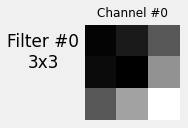

In [98]:
fig_filters = sbs_cnn1.visualize_filters('conv1', cmap='gray')

### Capturing Outputs

In [99]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

sbs_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = iter(val_loader).next()
logits = sbs_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

sbs_cnn1.remove_hooks()

### Visualizing Feature Maps

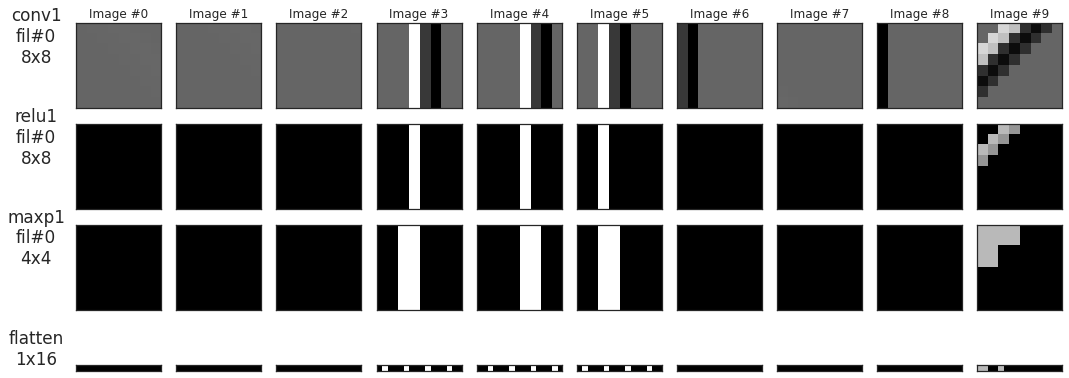

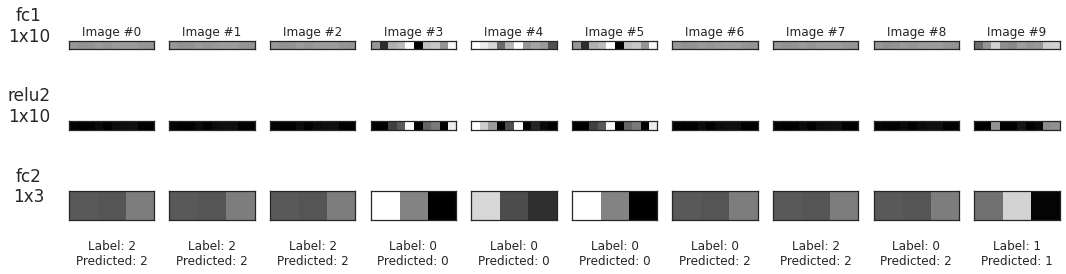

In [100]:
with plt.style.context('seaborn-white'):
    fig_maps1 = sbs_cnn1.visualize_outputs(featurizer_layers)
    fig_maps2 = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)    

### Accuracy

In [101]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

tensor([[59, 67],
        [55, 62],
        [71, 71]])